In [6]:
library(ggplot2)
library(ggrepel)
library(RColorBrewer)
library(tidyverse)

In [2]:
#import collapsed genetable
genetable_collapsed <- na.omit(read.table('hl60_exp1/DAC_genetable_collapsed.txt', header = FALSE, #skip = 4, 
                                  sep = '\t', na.strings = ' '))

genetable_collapsed[4,3:length(genetable_collapsed)] = apply(genetable_collapsed[1:4,3:length(genetable_collapsed)], 2, paste, collapse="_")
colnames(genetable_collapsed) <- genetable_collapsed[4,]
genetable_collapsed = genetable_collapsed[5:dim(genetable_collapsed)[1],] %>% data.frame

In [13]:
get_score_df <- function(genetable_collapsed,score,up_hit='resistance_hit',down_hit='sensitivity_hit',threshold = 4){
    df = genetable_collapsed[,c('gene', 
                                paste0(score,'_ave_Rep1_Rep2_Mann.Whitney.p.value_'),
                                paste0(score,'_ave_Rep1_Rep2_average.phenotype.of.strongest.3_'))
          # which (unlist(gregexpr('rho_ave_Rep1_Rep2', colnames(genetable_collapsed))) == 1))
    ] %>% remove_rownames
    rownames(df) = seq(length=nrow(df))

    colnames(df) <- c('gene','pvalue','score')

    df$score = df$score %>% as.double
    df$pvalue = df$pvalue %>% as.double

    #create dataframe with pseudogene phenotypes
    df$label = '.'

    df %>% mutate(label = replace(label, grepl('pseudo', df[[1]], fixed = TRUE), 'pseudo')) -> df

    pseudo_sd <- df %>% filter(label=='pseudo') %>% select(score) %>% as.list %>% unlist %>% sd

    df %>%
        mutate(label = replace(
            label,score > 0 & label != "pseudo" & score / pseudo_sd * -log10(pvalue) >= threshold,
            up_hit
        ))-> df
    df %>%
        mutate(label = replace(
            label,score < 0 & label != "pseudo" & score / pseudo_sd * -log10(pvalue) <= -threshold,
            down_hit
        )) -> df
    df %>% mutate(label = replace(label, label == '.', 'gene_non_hit')) -> df

    # reorder factors
    df$label <- factor(df$label, levels = c(down_hit, up_hit,'gene_non_hit','pseudo'))
    
    out = list()
    out[["data"]] = df
    out[["pseudo_sd"]] = pseudo_sd
    return(out)
}

In [14]:
# scale_color_manual(values = c('#3182bd', '#de2d26'),
#                    labels = c('Sensitizing Hits', 'Resistance Hits'))

plot_volcano <- function(df, pseudo_sd, score = 'rho',threshold = 4,
                         up_hit='resistance_hit',down_hit='sensitivity_hit'){
    
    draw_threshold <- function(x){threshold * pseudo_sd * sign(x)/(x)}

    p <- df %>% drop_na %>%
        ggplot(aes(x=score,y=-1*log10(pvalue)) ) + 
        geom_point(
            data = df %>% filter(label=='pseudo'), 
            alpha=1/100, size = 1, color = 'gray80') +
        geom_point(
            data = df %>% filter(label=='gene_non_hit'), 
            alpha=10/100, size = 1, color = 'gray90') +
        geom_point(
            data = df %>% filter(label==up_hit), 
            alpha=80/100, size = 2, color = '#fcae91') + 
        geom_point(
            data = df %>% filter(label==down_hit), 
            alpha=80/100, size = 2, color = '#bdd7e7') 
    
    if (score == 'gamma'){
        p + xlab(expression('CRISPRi control phenotype (' * gamma * ')')) -> p
    } 
    if (score == 'rho'){
        p + xlab(expression('CRISPRi decitabine phenotype (' * rho * ')')) -> p
    }
    p +
        theme_classic() +
        xlim(-1.0, 1.0) +
        scale_y_continuous(limits = c(0.5,4.5)) +
        ylab(expression('-log'[10] * '(Mann-Whitney p-value)')) +
        stat_function(fun = draw_threshold, linetype = 'dashed', color = 'black') -> p
    
    return(p)
}

label_sensitivity_hit <- function(p,dd, t_x = -0.2, t_y = -0.1){
    p + geom_point(
        data = dd, 
        size = 3, shape=21,
        stroke=0.5, 
        colour = "grey30", fill = "#3182bd"
    ) + 
    geom_text_repel(data = dd,
                    aes(label=gene),
                    color = 'black', size = 4.5, nudge_x = t_x, nudge_y = t_y)
}

label_resistance_hit <- function(p,dd, t_x = 0.2, t_y = 0.1){
    p + geom_point(
        data = dd, 
        size = 3, shape=21,
        stroke=0.5, 
        colour = "grey30", fill = "#de2d26"
    ) + 
    geom_text_repel(data = dd,
                    aes(label=gene),
                    color = 'black', size = 4.5, nudge_x = t_x, nudge_y = t_y)
}

### rho – $\rho$

In [15]:
rho = get_score_df(genetable_collapsed,"rho")

In [17]:
rho$data %>% group_by(label) %>% count

label,n
<fct>,<int>
sensitivity_hit,469
resistance_hit,377
gene_non_hit,19678
pseudo,20524


In [18]:
rho$p = plot_volcano(rho$data,rho$pseudo_sd,score='rho')

In [22]:
p1 = rho$p

### Genes to label:
# 1. Decapping proteins: DCP2, DCP1A, DCPS
p1 <- label_sensitivity_hit(p1, rho$data %>% filter(gene %in% c('DCP2','DCP1A', 'DCPS')))
# 2. BCL2 family proteins: DCL2, MCL1
p1 <- label_sensitivity_hit(p1, rho$data %>% filter(gene %in% c('BCL2')), t_y=+0.1)
p1 <- label_sensitivity_hit(p1, rho$data %>% filter(gene %in% c('MCL1')), t_x = -0.3, t_y = -0.4)
# 3. Positive controls: DCK, SLC29A1
p1 <- label_resistance_hit(p1, rho$data %>% filter(gene %in% c('DCK','SLC29A1')),t_y=-0.2)
# 4. m6A writers: METTL3, CBLL1, ZC3H13, KIAA1429
p1 <- label_resistance_hit(p1, rho$data %>% filter(gene %in% c('METTL3', 'KIAA1429')))
p1 <- label_resistance_hit(p1, rho$data %>% filter(gene %in% c('CBLL1')),t_y=+0.2)
p1 <- label_resistance_hit(p1, rho$data %>% filter(gene %in% c('ZC3H13')),t_y=-0.1)
# 5. target genes: SQLE, INTS5, MYBBP1A
p1 <- label_sensitivity_hit(p1, rho$data %>% filter(gene %in% c('SQLE', 'INTS5', 'MYBBP1A')))

In [23]:
p1 <- p1 + theme(axis.text.x = element_text(size = 15, color = 'black'),
          axis.text.y = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 16),
          axis.title.y = element_text(size = 16),
          legend.title = element_blank(),
          legend.text = element_text(size = rel(1.5), color = 'black'),
          legend.position = 'right'
          )

Warning message:
“Removed 13796 rows containing missing values (geom_point).”
Warning message:
“Removed 12778 rows containing missing values (geom_point).”
Warning message:
“Removed 54 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_text_repel).”


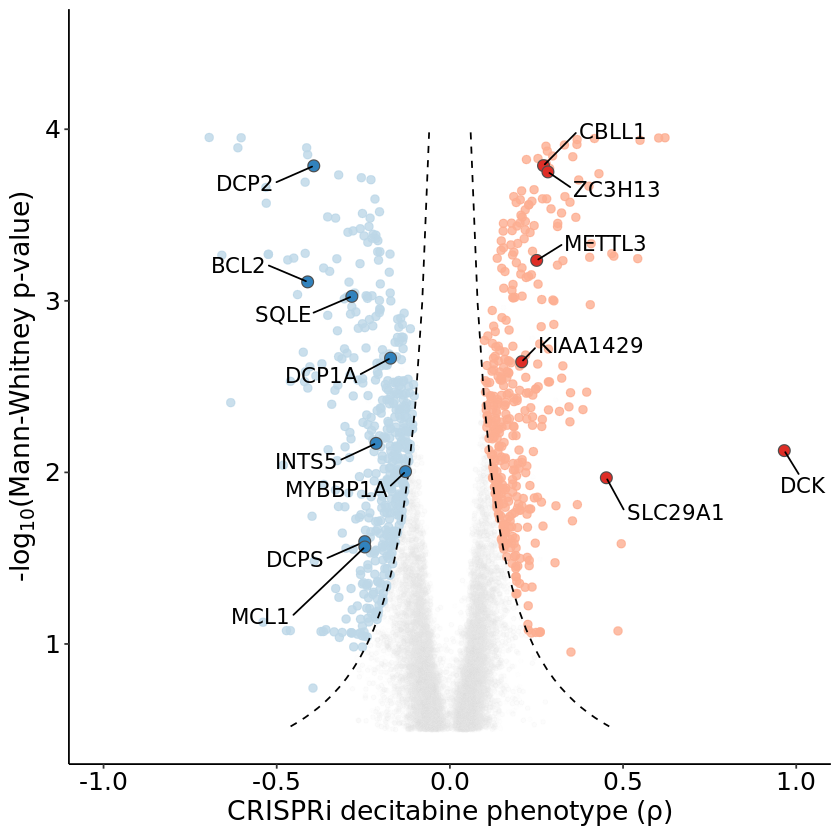

In [24]:
p1 

In [25]:
ggsave('plots/CRISPRi-rho_volcano_v3.pdf',p1, width = 6, height = 6)

Warning message:
“Removed 13796 rows containing missing values (geom_point).”
Warning message:
“Removed 12778 rows containing missing values (geom_point).”
Warning message:
“Removed 54 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_text_repel).”


In [81]:
paste0(
    rho$data %>% filter(label %in% c('sensitivity_hit','resistance_hit')) %>% nrow,
    " genes modulate cellular response to decitabine "
)

[1] "846 genes modulate cellular response to decitabine "

### gamma – $\gamma$

In [26]:
gamma = get_score_df(genetable_collapsed, 'gamma',up_hit = 'up',down_hit = 'down')

In [27]:
gamma$data %>% group_by(label) %>% count

label,n
<fct>,<int>
down,1743
up,164
gene_non_hit,18617
pseudo,20524


In [28]:
# gamma$data %>% filter(label == 'up')

Warning message:
“Removed 13897 rows containing missing values (geom_point).”
Warning message:
“Removed 12072 rows containing missing values (geom_point).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”
Warning message:
“Removed 80 row(s) containing missing values (geom_path).”


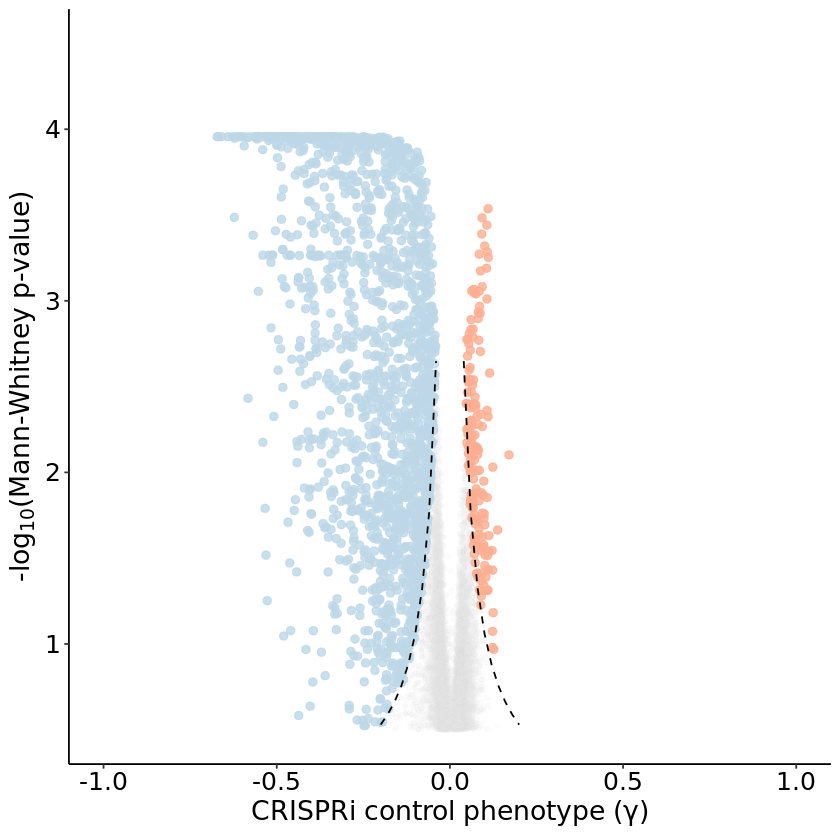

In [212]:
gamma$vol = plot_volcano(gamma$data,gamma$pseudo_sd,score='gamma',up_hit = 'up',down_hit = 'down')

gamma$vol + theme(axis.text.x = element_text(size = 15, color = 'black'),
          axis.text.y = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 16),
          axis.title.y = element_text(size = 16),
          legend.title = element_blank(),
          legend.text = element_text(size = rel(1.5), color = 'black'),
          legend.position = 'right'
) -> gamma$vol
gamma$vol

In [213]:
ggsave('plots/CRISPRi-gamma_volcano_v1.pdf',gamma$vol, width = 6, height = 6)

Warning message:
“Removed 13897 rows containing missing values (geom_point).”
Warning message:
“Removed 12072 rows containing missing values (geom_point).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”
Warning message:
“Removed 80 row(s) containing missing values (geom_path).”


In [69]:
paste0(gamma$data %>% filter(label == 'down') %>% nrow," essential genes")

[1] "1743 essential genes"

### gamma vs rho

In [37]:
df = data.frame(x=rho$data$score, y=gamma$data$score, 
           gene=rho$data$gene,
           rho=rho$data$label, gamma=gamma$data$label
          ) %>% drop_na

In [45]:
df %>% arrange(desc(abs(x))) %>% head(10)

,x,y,gene,rho,gamma
,<dbl>,<dbl>,<chr>,<fct>,<fct>
1,0.9655566,-0.03339194,DCK,resistance_hit,gene_non_hit
2,-0.6949500,-0.18818409,DDA1,sensitivity_hit,down
3,-0.6585576,-0.24710350,CSDE1,sensitivity_hit,down
4,-0.6327768,0.11256343,RASA2,sensitivity_hit,up
5,0.6211114,-0.36480650,MRGBP,resistance_hit,down
6,-0.6121558,-0.06461674,SCAF8,sensitivity_hit,gene_non_hit
7,0.6027516,-0.35143402,SHOC2,resistance_hit,down
8,-0.6026707,0.01373934,PTPN7,sensitivity_hit,gene_non_hit
9,0.5490393,-0.19212586,CPD,resistance_hit,down


In [46]:
df %>% arrange(desc(abs(y))) %>% filter(rho !='gene_non_hit') %>% head (10)

,x,y,gene,rho,gamma
,<dbl>,<dbl>,<chr>,<fct>,<fct>
1,-0.4719095,-0.5938508,NSMCE1,sensitivity_hit,down
2,-0.2848393,-0.5321275,AFG3L2,sensitivity_hit,down
3,0.4854053,-0.5293089,GNPNAT1,resistance_hit,down
4,0.2479983,-0.5174507,SNX15,resistance_hit,down
5,0.3496005,-0.5165883,NPC2,resistance_hit,down
6,-0.2850830,-0.5036572,PFDN2,sensitivity_hit,down
7,-0.2385115,-0.4988968,GINS1,sensitivity_hit,down
8,0.2607702,-0.4967019,CENPM,resistance_hit,down
9,0.2289055,-0.4872882,POLG2,resistance_hit,down


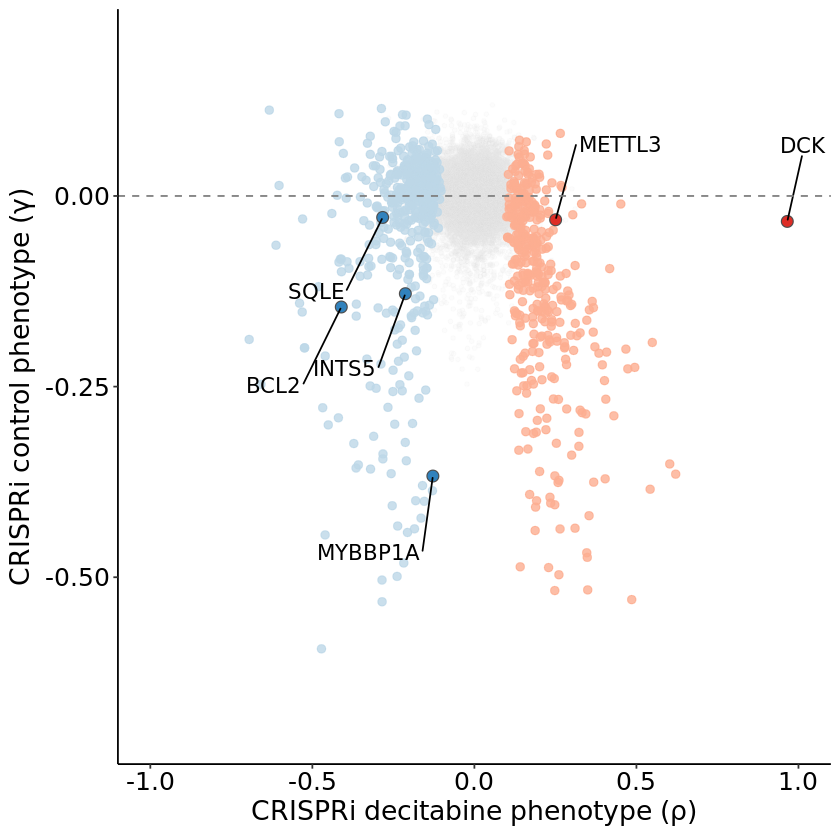

In [58]:
df %>% ggplot(aes(x=x, y=y)) + 
    geom_point(
        data = df %>% filter(gamma=='gene_non_hit' & rho=='gene_non_hit'), 
        alpha=10/100, size = 1, color = 'gray90') +
    # geom_point(
    #     data = df %>% filter(gamma=='pseudo'), 
    #     alpha=1/100, size = 1, color = 'yellow') +
    geom_point(
        data = df %>% filter(rho=='resistance_hit'), 
        alpha=80/100, size = 2, color = '#fcae91') + 
    geom_point(
        data = df %>% filter(rho=='sensitivity_hit'), 
        alpha=80/100, size = 2, color = '#bdd7e7') +
    theme_classic() +
    xlim(-1.0, 1.0) +
    ylim(-0.7, 0.2) +
    ylab(expression('CRISPRi control phenotype (' * gamma * ')')) +
    xlab(expression('CRISPRi decitabine phenotype (' * rho * ')')) +
    theme(axis.text.x = element_text(size = 15, color = 'black'),
          axis.text.y = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 16),
          axis.title.y = element_text(size = 16),
          legend.title = element_blank(),
          legend.text = element_text(size = rel(1.5), color = 'black'),
          legend.position = 'right'
) -> pp

pp <- label_sensitivity_hit(pp, df %>% filter(gene %in% c(
    'BCL2','SQLE', 'INTS5', 'MYBBP1A'
)))
pp <- label_resistance_hit(pp, df %>% filter(gene %in% c(
    'DCK','METTL3'
)))

pp + geom_hline(yintercept = 0,linetype = 'dashed', color = 'gray50') -> pp
pp

In [51]:
ggsave('plots/CRISPRi-rho_vs_gamma_v1.pdf',pp, width = 6, height = 6)

# 

In [84]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /data_gilbert/home/aarab/anaconda3/envs/deseq2/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] forcats_0.5.1      stringr_1.4.0      dplyr_1.0.7        purrr_0.3.4       
 [5] readr_2.0.2        tidyr_1.1.4        tibble_3.1.6       tidyverse_1.3.1   
 [9] RColorBrewer_1.1-2 ggrepel_0.9.1      ggplot2_3.3.5     

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-6     

In [68]:
# no_negs_res <- no_negs[c('DCK', 'SLC29A1', 'METTL3', 'YTHDF2', 'KIAA1429', 'CBLL1', 'ZC3H13'),]
# no_negs_res$cat2 <- ifelse(no_negs_res[[1]] %in% c('DCK', 'SLC29A1'), 'drug', 'm6a')
# no_negs_res <- no_negs[no_negs$V1 %in% c('DCK', 'SLC29A1'),]
# no_negs_sens <- no_negs[c('BCL2', 'MCL1', 'DCP2', 'DCPS', 'EDC3', 'DCP1A', 'CMTR2', 'LSM14A', 'CSDE1', 'PUM1', 'ZC3H18'),]
# no_negs_sens$cat2 <- ifelse(no_negs_sens[[1]] %in% c('BCL2', 'MCL1'), 'bcl2', 'decap')
# no_negs_sens <- no_negs[no_negs$V1 %in% c('BCL2', 'DCP2', 'DCPS', 'EDC3', 'DCP1A'),]
# no_negs_labels <- rbind(no_negs_res, no_negs_sens)
# head(no_negs_labels, n = 15)

# # reorder factors
# no_negs_labels$cat <- factor(no_negs_labels$cat, levels = c('sensitizing_hit', 'resistance_hit'))

# scale_shape_manual(values = c(16, 16, 16, 16), 
#                    labels = c('BCL-2 family', 'mRNA decapping', 'Drug metabolism', 'RNA methylation')) +
# scale_shape_manual(values = c(16, 16), 
#                    labels = c('Sensitizing Hits', 'Resistance Hits')) +
# geom_text_repel(data = no_negs[c('METTL3'),], 
# geom_text_repel(data = no_negs[c('DCK'),], 
# geom_text_repel(data = no_negs[c('SLC29A1'),], 
# geom_text_repel(data = no_negs[c('BCL2'),],
# geom_text_repel(data = no_negs[c('MCL1'),],
# geom_text_repel(data = no_negs[c('DCP2'),],
# geom_text_repel(data = no_negs[c('DCPS'),],
# geom_text_repel(data = no_negs[c('DCP1A'),],
# geom_text_repel(data = no_negs[c('EDC3'),],

# no_negs_res$cat2 <- ifelse(no_negs_res[[1]] %in% c('DCK', 'SLC29A1'), 'drug', 'm6a')
# no_negs_sens <- no_negs[c('TAF6L', 'SUPT20H', 'CCDC101', 'USP22'),]
# no_negs_sens$cat2 <- ('saga')
# no_negs_labels <- rbind(no_negs_res, no_negs_sens)

# head(no_negs_labels, n = 15)

# p <- ggplot(no_negs, aes(x = V29, y = -1 * log(V28, 10), label = V1)) +
# geom_point(data = no_negs, size = 1, color = 'gray90') +
# geom_point(data = resistance_hits, size = 1, color = '#fcae91') + 
# geom_point(data = sensitivity_hits, size = 1, color = '#bdd7e7') +
# theme_classic()+
# xlim(-1.0, 1.0) +
# scale_y_continuous(limits = c(0.5,4.7)) +
# xlab(expression('CRISPRi DNMTi phenotype (' * rho * ')')) +
# ylab(expression('-log'[10] * '(Mann-Whitney p-value)')) +
# theme(axis.text.x = element_text(size = 15, color = 'black'),
#       axis.text.y = element_text(size = 15, color = 'black'),
#       axis.title.x = element_text(size = 20),
#       axis.title.y = element_text(size = 20),
#       legend.title = element_blank(),
#       legend.text = element_text(size = rel(1.5), color = 'black'),
#       legend.position = 'none'
#       ) +

# stat_function(fun = draw_threshold_neg, linetype = 'dashed', color = 'black') +
# stat_function(fun = draw_threshold_pos, linetype = 'dashed', color = 'black')+
# geom_point(data = no_negs_labels, shape = 16, color = '#3182bd', size = 4) +
# geom_text_repel(data = no_negs[c('SUPT20H'),], 
#                 color = 'black', size = 4.5, nudge_x = -0.3, nudge_y = 0.05) +
# geom_text_repel(data = no_negs[c('TAF6L'),], 
#                 color = 'black', size = 4.5, nudge_x = -0.2) +
# geom_text_repel(data = no_negs[c('USP22'),], 
#                 color = 'black', size = 4.5, nudge_x = -0.25, nudge_y = -0.27) +
# geom_text_repel(data = no_negs[c('CCDC101'),], 
#                 color = 'black', size = 4.5, nudge_x = -0.4, nudge_y = -0.1)

# p

# ggsave(file = 'ray_volcano_plot_v2.eps', height = 5.5, width = 5.5)